## Import dependencies

In [ ]:
pip install mysql-connector-python

In [200]:
# Import dependencies
import pandas as pd
from sqlalchemy import create_engine
#import psycopg2

import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
import statsmodels.api as sm
import matplotlib

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


from pylab import rcParams

## Connect to PostgreSQL

In [ ]:
#Create a connection to the Postgres & AWS
connection = psycopg2.connect(
    host = 'finalproject-ml.cvm9etk63tz8.us-west-1.rds.amazonaws.com',
    port = 5432,
    user = 'postgres',
    password = '******',
    database = '*****'
    )
cursor=connection.cursor()

## Read File

In [ ]:
#Read in Table for aqi_all
aqi_all = "select * from aqi_all"

In [ ]:

#Check DataFrame
aqi_all = pd.read_sql(aqi_all, con=connection)
aqi_all.head()

##then I have to store the consolidated results in aws
## use SQLAlchemy to_sql

In [7]:
##temporary will go away eventurally
data = pd.read_csv('aqi_all_.csv')
data.head()

,Date,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
0,2015-01-01,7.0,37.0,26.0,55.0,NaN,55.0
1,2015-01-02,8.0,42.0,20.0,73.0,NaN,73.0
2,2015-01-03,10.0,45.0,17.0,84.0,NaN,84.0
3,2015-01-04,10.0,40.0,19.0,86.0,NaN,86.0
4,2015-01-05,9.0,42.0,12.0,69.0,NaN,69.0


In [9]:
data.tail()

,Date,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
2187,2020-12-27,6.0,19.0,23.0,28.0,NaN,28.0
2188,2020-12-28,6.0,24.0,28.0,23.0,NaN,28.0
2189,2020-12-29,8.0,25.0,19.0,35.0,18.0,35.0
2190,2020-12-30,8.0,24.0,32.0,22.0,NaN,32.0
2191,2020-12-31,7.0,25.0,32.0,33.0,NaN,33.0


## Prepare Data

In [8]:
#Check Data types
data.dtypes

Date           object
aqi_co        float64
aqi_no2       float64
aqi_o3        float64
aqi_pm_2_5    float64
aqi_pm_10     float64
AQI_Max       float64
dtype: object

In [10]:
# Convert the Date column to type DATETIME
data['Date'] = pd.to_datetime(data['Date'])

In [11]:
#Check Data types
data.dtypes

Date          datetime64[ns]
aqi_co               float64
aqi_no2              float64
aqi_o3               float64
aqi_pm_2_5           float64
aqi_pm_10            float64
AQI_Max              float64
dtype: object

In [13]:
## Check for number of columns and rows
data.shape

(2192, 7)

In [14]:
#Handle missing values
data.isnull().sum()

Date             0
aqi_co          28
aqi_no2         30
aqi_o3          28
aqi_pm_2_5      51
aqi_pm_10     2011
AQI_Max          1
dtype: int64

In [27]:
# Replace missing values with the mean of the column
df_column = ['aqi_co', 'aqi_no2', 'aqi_o3', 'aqi_pm_2_5', 'aqi_pm_10', 'AQI_Max']

for i in df_column:
    a = data[i].mean()
    data[i].replace(np.nan , a,inplace = True)

In [28]:
data.isnull().sum()

Date          0
aqi_co        0
aqi_no2       0
aqi_o3        0
aqi_pm_2_5    0
aqi_pm_10     0
AQI_Max       0
dtype: int64

In [33]:
data.head()

,Date,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
0,2015-01-01,7.0,37.0,26.0,55.0,16.812155,55.0
1,2015-01-02,8.0,42.0,20.0,73.0,16.812155,73.0
2,2015-01-03,10.0,45.0,17.0,84.0,16.812155,84.0
3,2015-01-04,10.0,40.0,19.0,86.0,16.812155,86.0
4,2015-01-05,9.0,42.0,12.0,69.0,16.812155,69.0


## Create Scenarios

## Scenario 1: 01/01/2015 - 12/31/2019 
## 0% Reduction in Human Activity 

In [48]:
## Applying filters to dates

start_dateE1 = "2015-1-1"
end_dateE1 = "2019-12-31"

after_start_dateE1 = data["Date"] >= start_dateE1
before_end_dateE1 = data["Date"] <= end_dateE1
between_two_datesE1 = after_start_dateE1 & before_end_dateE1
E1 = data.loc[between_two_datesE1]

E1.shape

(1826, 7)

In [60]:
E1.head()

,Date,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
0,2015-01-01,7.0,37.0,26.0,55.0,16.812155,55.0
1,2015-01-02,8.0,42.0,20.0,73.0,16.812155,73.0
2,2015-01-03,10.0,45.0,17.0,84.0,16.812155,84.0
3,2015-01-04,10.0,40.0,19.0,86.0,16.812155,86.0
4,2015-01-05,9.0,42.0,12.0,69.0,16.812155,69.0


In [59]:
E1.tail()

,Date,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
1821,2019-12-27,8.0,32.0,20.000000,34.0,16.812155,34.0
1822,2019-12-28,8.0,25.0,18.000000,38.0,16.812155,38.0
1823,2019-12-29,5.0,16.0,23.000000,27.0,16.812155,27.0
1824,2019-12-30,7.0,25.0,19.000000,31.0,16.812155,31.0
1825,2019-12-31,9.0,28.0,27.583641,41.0,16.812155,41.0


In [61]:
# Set date as the index
E1 = E1.reset_index()

E1 = E1.set_index('Date')
E1.index
E1.head()

,index,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
Date,,,,,,,
2015-01-01,0,7.0,37.0,26.0,55.0,16.812155,55.0
2015-01-02,1,8.0,42.0,20.0,73.0,16.812155,73.0
2015-01-03,2,10.0,45.0,17.0,84.0,16.812155,84.0
2015-01-04,3,10.0,40.0,19.0,86.0,16.812155,86.0
2015-01-05,4,9.0,42.0,12.0,69.0,16.812155,69.0


In [62]:
E1.describe()

,index,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
count,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000
mean,912.500000,5.252303,20.668100,27.217283,33.717667,16.759130,39.815045
std,527.265114,2.545146,13.002002,8.242755,21.729300,2.727053,18.143894
min,0.000000,0.000000,0.000000,3.000000,0.000000,2.000000,3.000000
25%,456.250000,3.000000,9.000000,22.000000,20.000000,16.812155,30.000000
50%,912.500000,5.000000,19.000000,27.000000,31.000000,16.812155,36.000000
75%,1368.750000,7.000000,30.000000,32.000000,45.000000,16.812155,46.000000
max,1825.000000,18.000000,71.000000,108.000000,228.000000,61.000000,228.000000


In [79]:
# Vizualizing all Pollutants 

figE1 = make_subplots(
    rows=6, cols=1,
    #specs=[[{}, {}],
          # [{"colspan": 6}, None]],
    subplot_titles=("aqi_co","aqi_no2","aqi_o3","aqi_pm_2_5",'aqi_pm_10','AQI_Max'))

figE1.add_trace(go.Bar(x=E1.index, y=E1['aqi_co'],
                    marker=dict(color=E1['aqi_co'],coloraxis="coloraxis")),
              1, 1)
figE1.add_trace(go.Bar(x=E1.index, y=E1['aqi_no2'],
                    marker=dict(color=E1['aqi_no2'], coloraxis="coloraxis")),
              2, 1)
figE1.add_trace(go.Bar(x=E1.index, y=E1['aqi_o3'],
                    marker=dict(color=E1['aqi_o3'], coloraxis="coloraxis")),
              3, 1)
figE1.add_trace(go.Bar(x=E1.index, y=E1['aqi_pm_2_5'],
                    marker=dict(color=E1['aqi_pm_2_5'], coloraxis="coloraxis")),
              4, 1)
figE1.add_trace(go.Bar(x=E1.index, y=E1['aqi_pm_10'],
                    marker=dict(color=E1['aqi_pm_10'], coloraxis="coloraxis")),
              5, 1)
figE1.add_trace(go.Bar(x=E1.index, y=E1['AQI_Max'],
                    marker=dict(color=E1['AQI_Max'], coloraxis="coloraxis")),
              6, 1)

figE1.update_layout(coloraxis=dict(colorscale='Temps'),showlegend=False,title_text="AQI Levels From 2015 to 2019")

figE1.update_layout(plot_bgcolor='white')

# figE1.update_layout( width=800,height=1200,shapes=[
#       dict(
#       type= 'line',
#       yref= 'paper', y0= 0, y1= 1,
#       xref= 'x', x0= '2020-01-01', x1= '2020-01-01'
#     )
# ])

figE1.update_layout( width=800,height=1200)

figE1.show()

In [118]:
## create new dataframe with AQI_Max

df_E1 = E1[["AQI_Max"]]
df_E1.head()

,AQI_Max
Date,
2015-01-01,55.0
2015-01-02,73.0
2015-01-03,84.0
2015-01-04,86.0
2015-01-05,69.0


In [121]:
resultE1=adfuller(df_E1['AQI_Max'])

In [122]:
#check that if the dataset is stationary or not
#Ho: It is non-stationary
#H1: It is stationary

def adfuller_test(AQI_Max):
    resultE1=adfuller(AQI_Max)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(resultE1,labels):
        print(label+' : '+str(value) )

if resultE1[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df_E1['AQI_Max'])

strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
ADF Test Statistic : -9.38090165329562
p-value : 6.961867113084149e-16
#Lags Used : 9
Number of Observations : 1816


In [123]:
#Here P-value is 6.961867113084149e-16 which is less than 0.05, which means data is rejecting the null hypothesis, 
#which means data is stationary

In [134]:
df_E1['AQI_Max First Difference'] = df_E1['AQI_Max'] - df_E1['AQI_Max'].shift(1)
df_E1['Seasonal First Difference']=df_E1['AQI_Max']-df_E1['AQI_Max'].shift(12)
df_E1.head()

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AQI_Max,AQI_Max First Difference,Seasonal First Difference
Date,,,
2015-01-01,55.0,NaN,NaN
2015-01-02,73.0,18.0,NaN
2015-01-03,84.0,11.0,NaN
2015-01-04,86.0,2.0,NaN
2015-01-05,69.0,-17.0,NaN


In [135]:
# Again testing if data is stationary


In [136]:
#see the first difference and seasonal difference
adfuller_test(df_E1['Seasonal First Difference'].dropna())

ADF Test Statistic : -10.51171486056942
p-value : 1.0204602514068493e-18
#Lags Used : 24
Number of Observations : 1789


In [137]:
#see the first difference and seasonal difference
adfuller_test(df_E1['AQI_Max First Difference'].dropna())

ADF Test Statistic : -14.588719808531792
p-value : 4.349280778703824e-27
#Lags Used : 21
Number of Observations : 1803


In [138]:
#Data is stationary:A stationary process has the property that the mean, variance and 
#autocorrelation structure do not change over time.

In [141]:
#Fit model
modelE1=ARIMA(df_E1['AQI_Max'],order=(1,1,1))
modelE1_fit=modelE1.fit()
modelE1_fit.summary()

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.AQI_Max   No. Observations:                 1825
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7085.171
Method:                       css-mle   S.D. of innovations             11.739
Date:                Wed, 28 Apr 2021   AIC                          14178.341
Time:                        19:16:41   BIC                          14200.379
Sample:                    01-02-2015   HQIC                         14186.470
                         - 12-31-2019                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0098      0.022     -0.435      0.663      -0.054       0.034
ar.L1.D.AQI_Max     0.7219      0.021     35.092      0.000       0.682       0.762
ma.L1.D.AQI_Max    -0.9779      0.008   -123.549      0.000      -0.993      -0.962
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3852           +0.0000j            1.3852            0.0000
MA.1            1.0226           +0.0000j            1.0226            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:>

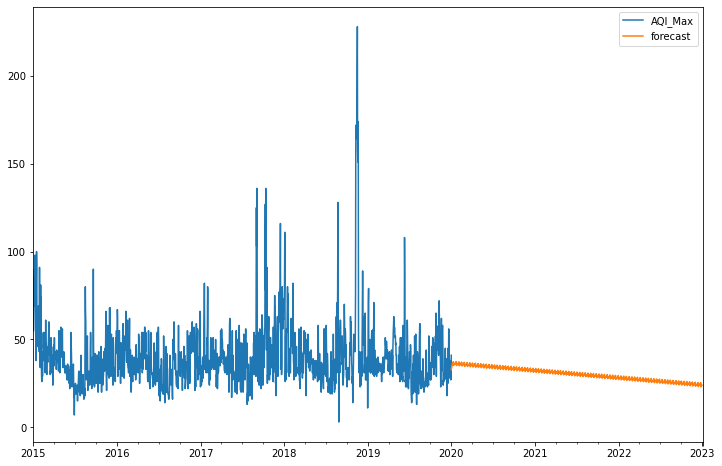

In [187]:
from pandas.tseries.offsets import DateOffset
future_datesE1=[df_E1.index[-1]+ DateOffset(days=x)for x in range(0,1100)]
future_datestE1_df=pd.DataFrame(index=future_datesE1[1:],columns=df_E1.columns)

future_datestE1_df.tail()

future_dfE1=pd.concat([df_E1,future_datestE1_df])

future_dfE1['forecast'] = results.predict(start = 1825, end = 2920, dynamic= True)#3650
future_dfE1[['AQI_Max', 'forecast']].plot(figsize=(12, 8))

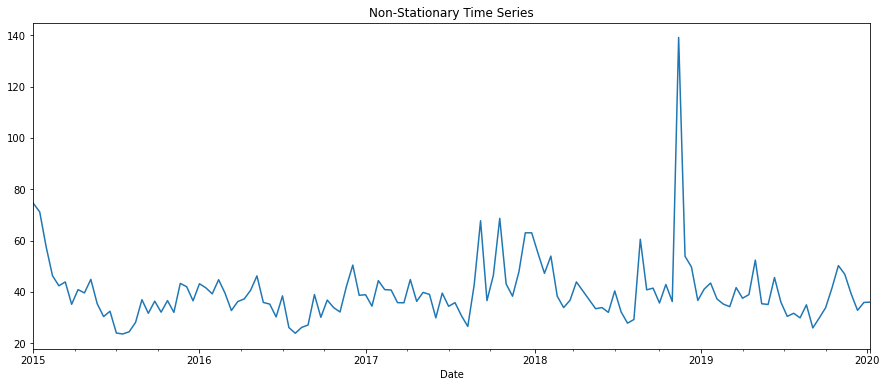

In [205]:
# Verifying & Vizualizing each pollutant's trend on a bi-weekly basis
AQI_Max = df_E1['AQI_Max'].resample('2W').mean()
AQI_Max.plot(figsize=(15, 6))
plt.title('Non-Stationary Time Series')
plt.show()

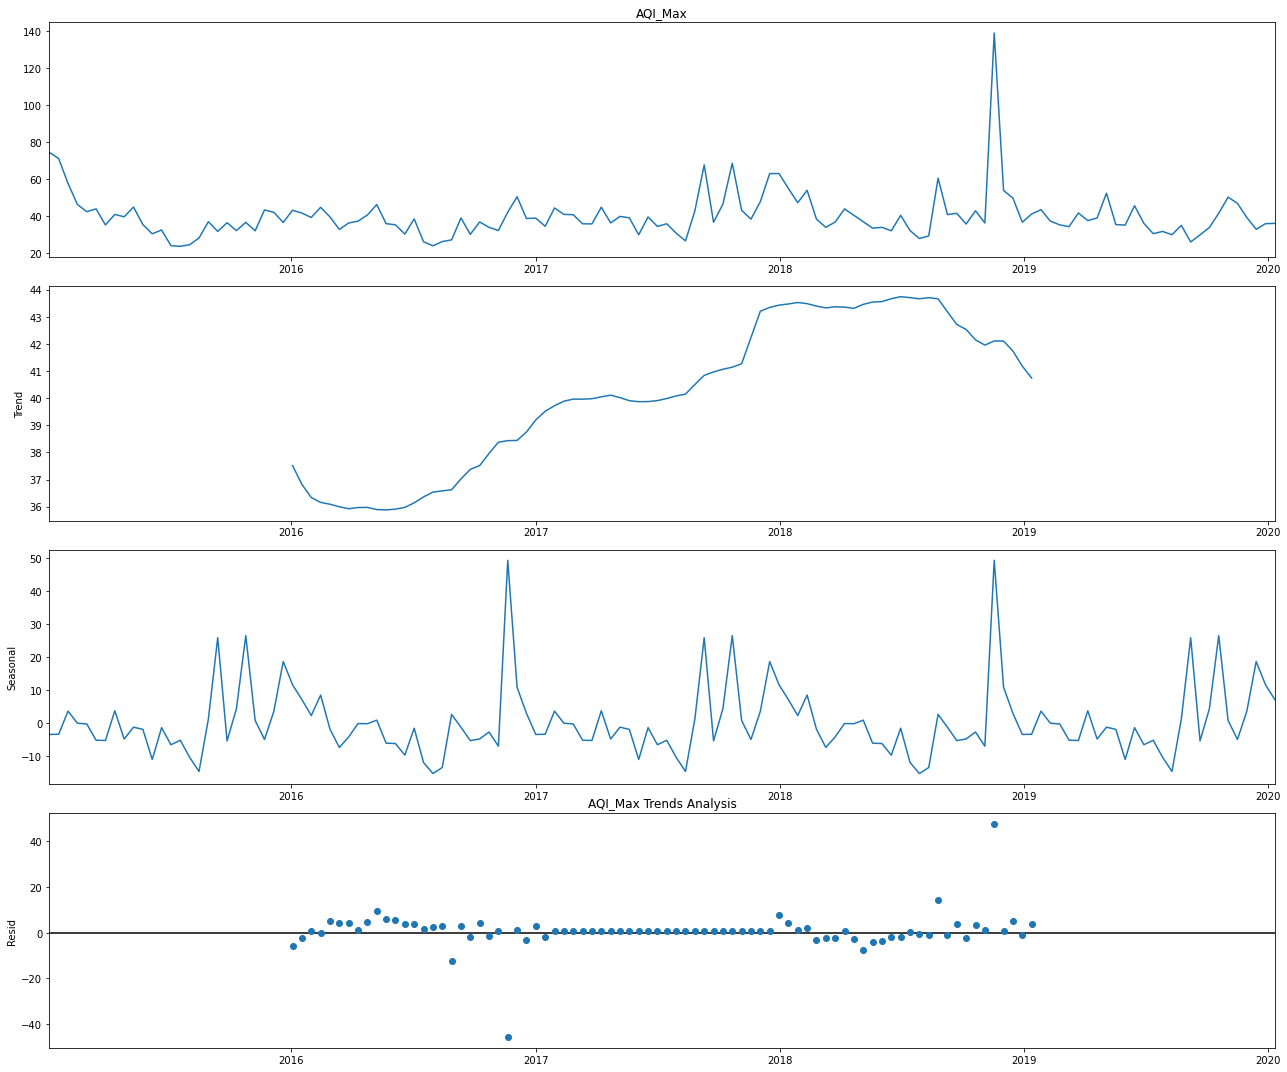

In [206]:
rcParams['figure.figsize'] = 18, 15
decomposition_max = sm.tsa.seasonal_decompose(AQI_Max, model='additive')
fig_max = decomposition_max.plot()
plt.title('AQI_Max Trends Analysis')
plt.show()

In [210]:
# SAMIRA Model for AQI_Max
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [215]:
# Model Fit iterating through to find seasonality for AQI_Max
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(AQI_Max,order=param,seasonal_order=param_seasonal, enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:134.83073579623425
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:15.047490739206387
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:6.0
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:11.104721801921196
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4.0
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:6.0
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:2.0
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:4.0
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:6.0
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:16.230416261563942


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-9.371461030649495
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:8.0
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4.0
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:8.0
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:4.0
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:8.0
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:6.0
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:8.0
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:6.0
ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:10.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(2, 2, 0, 12)12 - AIC:6.0
ARIMA(0, 0, 0)x(2, 2, 1, 12)12 - AIC:8.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:115.50179995112339
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 2, 12)12 - AIC:8.0
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:4.0
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(0, 1, 2, 12)12 - AIC:8.0
ARIMA(0, 0, 1)x(0, 2, 0, 12)12 - AIC:4.0
ARIMA(0, 0, 1)x(0, 2, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(0, 2, 2, 12)12 - AIC:8.0
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:17.1324947300425
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:8.0
ARIMA(0, 0, 1)x(1, 0, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 0, 1)x(1, 1, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 1)x(1, 2, 0, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 2, 1, 12)12 - AIC:8.0
ARIMA(0, 0, 1)x(1, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:8.0
ARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:10.0
ARIMA(0, 0, 1)x(2, 0, 2,

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:10.0
ARIMA(0, 0, 2)x(1, 0, 2, 12)12 - AIC:12.0
ARIMA(0, 0, 2)x(1, 1, 0, 12)12 - AIC:8.0
ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(0, 0, 2)x(1, 1, 2, 12)12 - AIC:12.0
ARIMA(0, 0, 2)x(1, 2, 0, 12)12 - AIC:8.0
ARIMA(0, 0, 2)x(1, 2, 1, 12)12 - AIC:10.0
ARIMA(0, 0, 2)x(1, 2, 2, 12)12 - AIC:12.0
ARIMA(0, 0, 2)x(2, 0, 0, 12)12 - AIC:10.0
ARIMA(0, 0, 2)x(2, 0, 1, 12)12 - AIC:12.0
ARIMA(0, 0, 2)x(2, 0, 2, 12)12 - AIC:14.0
ARIMA(0, 0, 2)x(2, 1, 0, 12)12 - AIC:10.0
ARIMA(0, 0, 2)x(2, 1, 1, 12)12 - AIC:12.0
ARIMA(0, 0, 2)x(2, 1, 2, 12)12 - AIC:14.0
ARIMA(0, 0, 2)x(2, 2, 0, 12)12 - AIC:10.0
ARIMA(0, 0, 2)x(2, 2, 1, 12)12 - AIC:12.0
ARIMA(0, 0, 2)x(2, 2, 2, 12)12 - AIC:14.0
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:92.27308094797255
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4.0
ARIMA(0, 1, 0)x(0, 0, 2, 12)12 - AIC:6.0
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:2.0
ARIMA(0, 1, 0)x(0, 2, 0, 12)12 - AIC:2.0
ARIMA(0, 1, 0)x(0, 2, 1, 12)12 - AIC:4.0
ARIMA(0, 1, 0)x(0, 2, 2, 12)

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 0)x(2, 2, 0, 12)12 - AIC:6.0
ARIMA(0, 1, 0)x(2, 2, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:86.21725237789192
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 1)x(0, 0, 2, 12)12 - AIC:8.0
ARIMA(0, 1, 1)x(0, 2, 0, 12)12 - AIC:4.0
ARIMA(0, 1, 1)x(0, 2, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 1)x(0, 2, 2, 12)12 - AIC:8.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-12.168757589657229
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 1)x(1, 0, 2, 12)12 - AIC:10.0
ARIMA(0, 1, 1)x(1, 2, 0, 12)12 - AIC:6.0
ARIMA(0, 1, 1)x(1, 2, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 1)x(1, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 1, 1)x(2, 0, 0, 12)12 - AIC:8.0
ARIMA(0, 1, 1)x(2, 0, 1, 12)12 - AIC:10.0
ARIMA(0, 1, 1)x(2, 0, 2, 12)12 - AIC:12.0
ARIMA(0, 1, 1)x(2, 2, 0, 12)12 - AIC:8.0
ARIMA(0, 1, 1)x(2, 2, 1, 12)12 - AIC:10.0
ARIMA(0, 1, 1)x(2, 2, 2, 12)12 - AIC:12.0
ARIMA(0, 1, 2)x(0, 0, 0, 12)12 - AIC:80.81922570591595
ARIMA(0, 1, 2)x(0, 0, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 2)x(0, 0, 2, 12)12 - AIC:10.0
ARIMA(0, 1, 2)x(0, 2, 0, 12)12 - AIC:6.0
ARIMA(0, 1, 2)x(0, 2, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 2)x(0, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 1, 2)x(1, 0, 0, 12)12 - AIC:-11.805799890661639
ARIMA(0, 1, 2)x(1, 0, 1, 12)12 - AIC:10.0
ARIMA(0, 1, 2)x(1, 0, 2, 12)12 - AIC:12.0
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:8.0
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:10.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 2, 0)x(1, 1, 0, 12)12 - AIC:4.0
ARIMA(0, 2, 0)x(1, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 2, 0)x(1, 1, 2, 12)12 - AIC:8.0
ARIMA(0, 2, 0)x(1, 2, 0, 12)12 - AIC:4.0
ARIMA(0, 2, 0)x(1, 2, 1, 12)12 - AIC:6.0
ARIMA(0, 2, 0)x(1, 2, 2, 12)12 - AIC:8.0
ARIMA(0, 2, 0)x(2, 0, 0, 12)12 - AIC:6.0
ARIMA(0, 2, 0)x(2, 0, 1, 12)12 - AIC:8.0
ARIMA(0, 2, 0)x(2, 0, 2, 12)12 - AIC:10.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 2, 0)x(2, 1, 0, 12)12 - AIC:6.0
ARIMA(0, 2, 0)x(2, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 2, 0)x(2, 1, 2, 12)12 - AIC:10.0
ARIMA(0, 2, 0)x(2, 2, 0, 12)12 - AIC:6.0
ARIMA(0, 2, 0)x(2, 2, 1, 12)12 - AIC:8.0
ARIMA(0, 2, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 2, 1)x(0, 0, 0, 12)12 - AIC:82.12730905892474
ARIMA(0, 2, 1)x(0, 0, 1, 12)12 - AIC:6.0
ARIMA(0, 2, 1)x(0, 0, 2, 12)12 - AIC:8.0
ARIMA(0, 2, 1)x(0, 1, 0, 12)12 - AIC:4.0
ARIMA(0, 2, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 2, 1)x(0, 1, 2, 12)12 - AIC:8.0
ARIMA(0, 2, 1)x(0, 2, 0, 12)12 - AIC:4.0
ARIMA(0, 2, 1)x(0, 2, 1, 12)12 - AIC:6.0
ARIMA(0, 2, 1)x(0, 2, 2, 12)12 - AIC:8.0
ARIMA(0, 2, 1)x(1, 0, 0, 12)12 - AIC:6.0
ARIMA(0, 2, 1)x(1, 0, 1, 12)12 - AIC:8.0
ARIMA(0, 2, 1)x(1, 0, 2, 12)12 - AIC:10.0
ARIMA(0, 2, 1)x(1, 1, 0, 12)12 - AIC:6.0
ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 2, 1)x(1, 1, 2, 12)12 - AIC:10.0
ARIMA(0, 2, 1)x(1, 2, 0, 12)12 - AIC:6.0
ARIMA(0, 2, 1)x(1, 2, 1, 12)12 - AIC:8.0
ARIMA(0, 2, 1)x(1, 2, 2, 12)12 - AIC:10

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 2, 2)x(0, 2, 1, 12)12 - AIC:8.0
ARIMA(0, 2, 2)x(0, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 2, 2)x(1, 0, 0, 12)12 - AIC:8.0
ARIMA(0, 2, 2)x(1, 0, 1, 12)12 - AIC:10.0
ARIMA(0, 2, 2)x(1, 0, 2, 12)12 - AIC:12.0
ARIMA(0, 2, 2)x(1, 1, 0, 12)12 - AIC:8.0
ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(0, 2, 2)x(1, 1, 2, 12)12 - AIC:12.0
ARIMA(0, 2, 2)x(1, 2, 0, 12)12 - AIC:8.0
ARIMA(0, 2, 2)x(1, 2, 1, 12)12 - AIC:10.0
ARIMA(0, 2, 2)x(1, 2, 2, 12)12 - AIC:12.0
ARIMA(0, 2, 2)x(2, 0, 0, 12)12 - AIC:10.0
ARIMA(0, 2, 2)x(2, 0, 1, 12)12 - AIC:12.0
ARIMA(0, 2, 2)x(2, 0, 2, 12)12 - AIC:14.0
ARIMA(0, 2, 2)x(2, 1, 0, 12)12 - AIC:10.0
ARIMA(0, 2, 2)x(2, 1, 1, 12)12 - AIC:12.0
ARIMA(0, 2, 2)x(2, 1, 2, 12)12 - AIC:14.0
ARIMA(0, 2, 2)x(2, 2, 0, 12)12 - AIC:10.0
ARIMA(0, 2, 2)x(2, 2, 1, 12)12 - AIC:12.0
ARIMA(0, 2, 2)x(2, 2, 2, 12)12 - AIC:14.0
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:100.70333651777304


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-8.281899586987745
ARIMA(1, 0, 0)x(0, 0, 2, 12)12 - AIC:8.0
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:-15.066512439912284
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(1, 0, 0)x(0, 1, 2, 12)12 - AIC:8.0
ARIMA(1, 0, 0)x(0, 2, 0, 12)12 - AIC:4.0
ARIMA(1, 0, 0)x(0, 2, 1, 12)12 - AIC:6.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 2, 2, 12)12 - AIC:8.0
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-6.132043208388918


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-8.953550178697068
ARIMA(1, 0, 0)x(1, 0, 2, 12)12 - AIC:10.0
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:6.0
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 0, 0)x(1, 1, 2, 12)12 - AIC:10.0
ARIMA(1, 0, 0)x(1, 2, 0, 12)12 - AIC:6.0
ARIMA(1, 0, 0)x(1, 2, 1, 12)12 - AIC:8.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(1, 2, 2, 12)12 - AIC:10.0
ARIMA(1, 0, 0)x(2, 0, 0, 12)12 - AIC:8.0
ARIMA(1, 0, 0)x(2, 0, 1, 12)12 - AIC:10.0
ARIMA(1, 0, 0)x(2, 0, 2, 12)12 - AIC:12.0
ARIMA(1, 0, 0)x(2, 1, 0, 12)12 - AIC:8.0
ARIMA(1, 0, 0)x(2, 1, 1, 12)12 - AIC:10.0
ARIMA(1, 0, 0)x(2, 1, 2, 12)12 - AIC:12.0
ARIMA(1, 0, 0)x(2, 2, 0, 12)12 - AIC:8.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(2, 2, 1, 12)12 - AIC:10.0
ARIMA(1, 0, 0)x(2, 2, 2, 12)12 - AIC:12.0
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:93.12476015546531
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:8.0
ARIMA(1, 0, 1)x(0, 0, 2, 12)12 - AIC:10.0
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:6.0
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 0, 1)x(0, 1, 2, 12)12 - AIC:10.0
ARIMA(1, 0, 1)x(0, 2, 0, 12)12 - AIC:6.0
ARIMA(1, 0, 1)x(0, 2, 1, 12)12 - AIC:8.0
ARIMA(1, 0, 1)x(0, 2, 2, 12)12 - AIC:10.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-4.750104336148315
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:10.0
ARIMA(1, 0, 1)x(1, 0, 2, 12)12 - AIC:12.0
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:8.0
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(1, 0, 1)x(1, 1, 2, 12)12 - AIC:12.0
ARIMA(1, 0, 1)x(1, 2, 0, 12)12 - AIC:8.0
ARIMA(1, 0, 1)x(1, 2, 1, 12)12 - AIC:10.0
ARIMA(1, 0, 1)x(1, 2, 2, 12)12 - AIC:12.0
ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC:10.0
ARIMA(1, 0, 1)x(2, 0, 1, 12)12 - AIC:12.0
ARIMA(1, 0, 1)x(2, 0, 2, 12)12 - AIC:14.0
ARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC:10.0
ARIMA(1, 0, 1)x(2, 1, 1, 12)12 - AIC:12.0
ARIMA(1, 0, 1)x(2, 1, 2, 12)12 - AIC:14.0
ARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC:10.0
ARIMA(1, 0, 1)x(2, 2, 1, 12)12 - AIC:12.0
ARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC:14.0
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:87.44503620120508
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:10.0
ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:12.0
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:8.0
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:10.0
ARIMA(1, 0

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:-4.167807620554909
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:12.0
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:14.0
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:10.0
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:12.0
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:14.0
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:10.0
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:12.0
ARIMA(1, 0, 2)x(1, 2, 2, 12)12 - AIC:14.0
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:12.0
ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:14.0
ARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:16.0
ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:12.0
ARIMA(1, 0, 2)x(2, 1, 1, 12)12 - AIC:14.0
ARIMA(1, 0, 2)x(2, 1, 2, 12)12 - AIC:16.0
ARIMA(1, 0, 2)x(2, 2, 0, 12)12 - AIC:12.0
ARIMA(1, 0, 2)x(2, 2, 1, 12)12 - AIC:14.0
ARIMA(1, 0, 2)x(2, 2, 2, 12)12 - AIC:16.0
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:93.81301770655065
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:6.0
ARIMA(1, 1, 0)x(0, 0, 2, 12)12 - AIC:8.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(0, 2, 0, 12)12 - AIC:4.0
ARIMA(1, 1, 0)x(0, 2, 1, 12)12 - AIC:6.0
ARIMA(1, 1, 0)x(0, 2, 2, 12)12 - AIC:8.0
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:6.0
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:8.0
ARIMA(1, 1, 0)x(1, 0, 2, 12)12 - AIC:10.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(1, 2, 0, 12)12 - AIC:6.0
ARIMA(1, 1, 0)x(1, 2, 1, 12)12 - AIC:8.0
ARIMA(1, 1, 0)x(1, 2, 2, 12)12 - AIC:10.0
ARIMA(1, 1, 0)x(2, 0, 0, 12)12 - AIC:8.0
ARIMA(1, 1, 0)x(2, 0, 1, 12)12 - AIC:10.0
ARIMA(1, 1, 0)x(2, 0, 2, 12)12 - AIC:12.0
ARIMA(1, 1, 0)x(2, 2, 0, 12)12 - AIC:8.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(2, 2, 1, 12)12 - AIC:10.0
ARIMA(1, 1, 0)x(2, 2, 2, 12)12 - AIC:12.0
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:88.11126981571309
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:8.0
ARIMA(1, 1, 1)x(0, 0, 2, 12)12 - AIC:10.0
ARIMA(1, 1, 1)x(0, 2, 0, 12)12 - AIC:6.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(0, 2, 1, 12)12 - AIC:8.0
ARIMA(1, 1, 1)x(0, 2, 2, 12)12 - AIC:10.0
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:8.0
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:10.0
ARIMA(1, 1, 1)x(1, 0, 2, 12)12 - AIC:12.0
ARIMA(1, 1, 1)x(1, 2, 0, 12)12 - AIC:8.0
ARIMA(1, 1, 1)x(1, 2, 1, 12)12 - AIC:10.0
ARIMA(1, 1, 1)x(1, 2, 2, 12)12 - AIC:12.0
ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:10.0
ARIMA(1, 1, 1)x(2, 0, 1, 12)12 - AIC:12.0
ARIMA(1, 1, 1)x(2, 0, 2, 12)12 - AIC:14.0
ARIMA(1, 1, 1)x(2, 2, 0, 12)12 - AIC:10.0
ARIMA(1, 1, 1)x(2, 2, 1, 12)12 - AIC:12.0
ARIMA(1, 1, 1)x(2, 2, 2, 12)12 - AIC:14.0
ARIMA(1, 1, 2)x(0, 0, 0, 12)12 - AIC:82.52765880115338
ARIMA(1, 1, 2)x(0, 0, 1, 12)12 - AIC:10.0
ARIMA(1, 1, 2)x(0, 0, 2, 12)12 - AIC:12.0
ARIMA(1, 1, 2)x(0, 2, 0, 12)12 - AIC:8.0
ARIMA(1, 1, 2)x(0, 2, 1, 12)12 - AIC:10.0
ARIMA(1, 1, 2)x(0, 2, 2, 12)12 - AIC:12.0
ARIMA(1, 1, 2)x(1, 0, 0, 12)12 - AIC:10.0
ARIMA(1, 1, 2)x(1, 0, 1, 12)12 - AIC:12.0
ARIMA(1, 1, 2)x(1, 0, 2, 12)12 - AIC:14.0
ARIMA(1, 1, 2)x(1, 2, 0, 

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 2, 0)x(0, 2, 0, 12)12 - AIC:4.0
ARIMA(1, 2, 0)x(0, 2, 1, 12)12 - AIC:6.0
ARIMA(1, 2, 0)x(0, 2, 2, 12)12 - AIC:8.0
ARIMA(1, 2, 0)x(1, 0, 0, 12)12 - AIC:6.0
ARIMA(1, 2, 0)x(1, 0, 1, 12)12 - AIC:8.0
ARIMA(1, 2, 0)x(1, 0, 2, 12)12 - AIC:10.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 2, 0)x(1, 1, 0, 12)12 - AIC:6.0
ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 2, 0)x(1, 1, 2, 12)12 - AIC:10.0
ARIMA(1, 2, 0)x(1, 2, 0, 12)12 - AIC:6.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 2, 0)x(1, 2, 1, 12)12 - AIC:8.0
ARIMA(1, 2, 0)x(1, 2, 2, 12)12 - AIC:10.0
ARIMA(1, 2, 0)x(2, 0, 0, 12)12 - AIC:8.0
ARIMA(1, 2, 0)x(2, 0, 1, 12)12 - AIC:10.0
ARIMA(1, 2, 0)x(2, 0, 2, 12)12 - AIC:12.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 2, 0)x(2, 1, 0, 12)12 - AIC:8.0
ARIMA(1, 2, 0)x(2, 1, 1, 12)12 - AIC:10.0
ARIMA(1, 2, 0)x(2, 1, 2, 12)12 - AIC:12.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 2, 0)x(2, 2, 0, 12)12 - AIC:8.0
ARIMA(1, 2, 0)x(2, 2, 1, 12)12 - AIC:10.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 2, 0)x(2, 2, 2, 12)12 - AIC:12.0
ARIMA(1, 2, 1)x(0, 0, 0, 12)12 - AIC:83.87087636168417
ARIMA(1, 2, 1)x(0, 0, 1, 12)12 - AIC:8.0
ARIMA(1, 2, 1)x(0, 0, 2, 12)12 - AIC:10.0
ARIMA(1, 2, 1)x(0, 1, 0, 12)12 - AIC:6.0
ARIMA(1, 2, 1)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 2, 1)x(0, 1, 2, 12)12 - AIC:10.0
ARIMA(1, 2, 1)x(0, 2, 0, 12)12 - AIC:6.0
ARIMA(1, 2, 1)x(0, 2, 1, 12)12 - AIC:8.0
ARIMA(1, 2, 1)x(0, 2, 2, 12)12 - AIC:10.0
ARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC:8.0
ARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:10.0
ARIMA(1, 2, 1)x(1, 0, 2, 12)12 - AIC:12.0
ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:8.0
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC:12.0
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:8.0
ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:10.0
ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:12.0
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:10.0
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:12.0
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:14.0
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:10.0
ARIMA(1, 2, 1)x(2, 1, 1, 12)1

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 0)x(0, 0, 1, 12)12 - AIC:-11.799040062464659
ARIMA(2, 0, 0)x(0, 0, 2, 12)12 - AIC:10.0
ARIMA(2, 0, 0)x(0, 1, 0, 12)12 - AIC:6.0
ARIMA(2, 0, 0)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(2, 0, 0)x(0, 1, 2, 12)12 - AIC:10.0
ARIMA(2, 0, 0)x(0, 2, 0, 12)12 - AIC:6.0
ARIMA(2, 0, 0)x(0, 2, 1, 12)12 - AIC:8.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 0)x(0, 2, 2, 12)12 - AIC:10.0
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:8.0
ARIMA(2, 0, 0)x(1, 0, 1, 12)12 - AIC:10.0
ARIMA(2, 0, 0)x(1, 0, 2, 12)12 - AIC:12.0
ARIMA(2, 0, 0)x(1, 1, 0, 12)12 - AIC:8.0
ARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(2, 0, 0)x(1, 1, 2, 12)12 - AIC:12.0
ARIMA(2, 0, 0)x(1, 2, 0, 12)12 - AIC:8.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 0)x(1, 2, 1, 12)12 - AIC:10.0
ARIMA(2, 0, 0)x(1, 2, 2, 12)12 - AIC:12.0
ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:10.0
ARIMA(2, 0, 0)x(2, 0, 1, 12)12 - AIC:12.0
ARIMA(2, 0, 0)x(2, 0, 2, 12)12 - AIC:14.0
ARIMA(2, 0, 0)x(2, 1, 0, 12)12 - AIC:10.0
ARIMA(2, 0, 0)x(2, 1, 1, 12)12 - AIC:12.0
ARIMA(2, 0, 0)x(2, 1, 2, 12)12 - AIC:14.0
ARIMA(2, 0, 0)x(2, 2, 0, 12)12 - AIC:10.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 0)x(2, 2, 1, 12)12 - AIC:12.0
ARIMA(2, 0, 0)x(2, 2, 2, 12)12 - AIC:14.0
ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:94.88631389982427
ARIMA(2, 0, 1)x(0, 0, 1, 12)12 - AIC:10.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 1)x(0, 0, 2, 12)12 - AIC:12.0
ARIMA(2, 0, 1)x(0, 1, 0, 12)12 - AIC:8.0
ARIMA(2, 0, 1)x(0, 1, 1, 12)12 - AIC:10.0
ARIMA(2, 0, 1)x(0, 1, 2, 12)12 - AIC:12.0
ARIMA(2, 0, 1)x(0, 2, 0, 12)12 - AIC:8.0
ARIMA(2, 0, 1)x(0, 2, 1, 12)12 - AIC:10.0
ARIMA(2, 0, 1)x(0, 2, 2, 12)12 - AIC:12.0
ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:10.0
ARIMA(2, 0, 1)x(1, 0, 1, 12)12 - AIC:12.0
ARIMA(2, 0, 1)x(1, 0, 2, 12)12 - AIC:14.0
ARIMA(2, 0, 1)x(1, 1, 0, 12)12 - AIC:10.0
ARIMA(2, 0, 1)x(1, 1, 1, 12)12 - AIC:12.0
ARIMA(2, 0, 1)x(1, 1, 2, 12)12 - AIC:14.0
ARIMA(2, 0, 1)x(1, 2, 0, 12)12 - AIC:10.0
ARIMA(2, 0, 1)x(1, 2, 1, 12)12 - AIC:12.0
ARIMA(2, 0, 1)x(1, 2, 2, 12)12 - AIC:14.0
ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:12.0
ARIMA(2, 0, 1)x(2, 0, 1, 12)12 - AIC:14.0
ARIMA(2, 0, 1)x(2, 0, 2, 12)12 - AIC:16.0
ARIMA(2, 0, 1)x(2, 1, 0, 12)12 - AIC:12.0
ARIMA(2, 0, 1)x(2, 1, 1, 12)12 - AIC:14.0
ARIMA(2, 0, 1)x(2, 1, 2, 12)12 - AIC:16.0
ARIMA(2, 0, 1)x(2, 2, 0, 12)12 - AIC:12.0
ARIMA(2, 0, 1)x(2, 2, 1, 12)12 - AIC

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 0)x(0, 2, 0, 12)12 - AIC:6.0
ARIMA(2, 1, 0)x(0, 2, 1, 12)12 - AIC:8.0
ARIMA(2, 1, 0)x(0, 2, 2, 12)12 - AIC:10.0
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:8.0
ARIMA(2, 1, 0)x(1, 0, 1, 12)12 - AIC:10.0
ARIMA(2, 1, 0)x(1, 0, 2, 12)12 - AIC:12.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC:8.0
ARIMA(2, 1, 0)x(1, 2, 1, 12)12 - AIC:10.0
ARIMA(2, 1, 0)x(1, 2, 2, 12)12 - AIC:12.0
ARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:10.0
ARIMA(2, 1, 0)x(2, 0, 1, 12)12 - AIC:12.0
ARIMA(2, 1, 0)x(2, 0, 2, 12)12 - AIC:14.0
ARIMA(2, 1, 0)x(2, 2, 0, 12)12 - AIC:10.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 0)x(2, 2, 1, 12)12 - AIC:12.0
ARIMA(2, 1, 0)x(2, 2, 2, 12)12 - AIC:14.0
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:85.01342507666611
ARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:10.0
ARIMA(2, 1, 1)x(0, 0, 2, 12)12 - AIC:12.0
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:8.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:10.0
ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - AIC:12.0
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:10.0
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:12.0
ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:14.0
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:10.0
ARIMA(2, 1, 1)x(1, 2, 1, 12)12 - AIC:12.0
ARIMA(2, 1, 1)x(1, 2, 2, 12)12 - AIC:14.0
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:12.0
ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:14.0
ARIMA(2, 1, 1)x(2, 0, 2, 12)12 - AIC:16.0
ARIMA(2, 1, 1)x(2, 2, 0, 12)12 - AIC:12.0
ARIMA(2, 1, 1)x(2, 2, 1, 12)12 - AIC:14.0
ARIMA(2, 1, 1)x(2, 2, 2, 12)12 - AIC:16.0
ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:80.92103179041877
ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:12.0
ARIMA(2, 1, 2)x(0, 0, 2, 12)12 - AIC:14.0
ARIMA(2, 1, 2)x(0, 2, 0, 12)12 - AIC:10.0
ARIMA(2, 1, 2)x(0, 2, 1, 12)12 - AIC:12.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 2)x(0, 2, 2, 12)12 - AIC:14.0
ARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:12.0
ARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:14.0
ARIMA(2, 1, 2)x(1, 0, 2, 12)12 - AIC:16.0
ARIMA(2, 1, 2)x(1, 2, 0, 12)12 - AIC:12.0
ARIMA(2, 1, 2)x(1, 2, 1, 12)12 - AIC:14.0
ARIMA(2, 1, 2)x(1, 2, 2, 12)12 - AIC:16.0
ARIMA(2, 1, 2)x(2, 0, 0, 12)12 - AIC:14.0
ARIMA(2, 1, 2)x(2, 0, 1, 12)12 - AIC:16.0
ARIMA(2, 1, 2)x(2, 0, 2, 12)12 - AIC:18.0
ARIMA(2, 1, 2)x(2, 2, 0, 12)12 - AIC:14.0
ARIMA(2, 1, 2)x(2, 2, 1, 12)12 - AIC:16.0
ARIMA(2, 1, 2)x(2, 2, 2, 12)12 - AIC:18.0
ARIMA(2, 2, 0)x(0, 0, 0, 12)12 - AIC:81.9976027822773
ARIMA(2, 2, 0)x(0, 0, 1, 12)12 - AIC:8.0
ARIMA(2, 2, 0)x(0, 0, 2, 12)12 - AIC:10.0
ARIMA(2, 2, 0)x(0, 1, 0, 12)12 - AIC:6.0
ARIMA(2, 2, 0)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(2, 2, 0)x(0, 1, 2, 12)12 - AIC:10.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 2, 0)x(0, 2, 0, 12)12 - AIC:6.0
ARIMA(2, 2, 0)x(0, 2, 1, 12)12 - AIC:8.0
ARIMA(2, 2, 0)x(0, 2, 2, 12)12 - AIC:10.0
ARIMA(2, 2, 0)x(1, 0, 0, 12)12 - AIC:8.0
ARIMA(2, 2, 0)x(1, 0, 1, 12)12 - AIC:10.0
ARIMA(2, 2, 0)x(1, 0, 2, 12)12 - AIC:12.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 2, 0)x(1, 1, 0, 12)12 - AIC:8.0
ARIMA(2, 2, 0)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(2, 2, 0)x(1, 1, 2, 12)12 - AIC:12.0
ARIMA(2, 2, 0)x(1, 2, 0, 12)12 - AIC:8.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 2, 0)x(1, 2, 1, 12)12 - AIC:10.0
ARIMA(2, 2, 0)x(1, 2, 2, 12)12 - AIC:12.0
ARIMA(2, 2, 0)x(2, 0, 0, 12)12 - AIC:10.0
ARIMA(2, 2, 0)x(2, 0, 1, 12)12 - AIC:12.0
ARIMA(2, 2, 0)x(2, 0, 2, 12)12 - AIC:14.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 2, 0)x(2, 1, 0, 12)12 - AIC:10.0
ARIMA(2, 2, 0)x(2, 1, 1, 12)12 - AIC:12.0
ARIMA(2, 2, 0)x(2, 1, 2, 12)12 - AIC:14.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 2, 0)x(2, 2, 0, 12)12 - AIC:10.0
ARIMA(2, 2, 0)x(2, 2, 1, 12)12 - AIC:12.0


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 2, 0)x(2, 2, 2, 12)12 - AIC:14.0
ARIMA(2, 2, 1)x(0, 0, 0, 12)12 - AIC:80.95466511373401
ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:10.0
ARIMA(2, 2, 1)x(0, 0, 2, 12)12 - AIC:12.0
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:8.0
ARIMA(2, 2, 1)x(0, 1, 1, 12)12 - AIC:10.0
ARIMA(2, 2, 1)x(0, 1, 2, 12)12 - AIC:12.0
ARIMA(2, 2, 1)x(0, 2, 0, 12)12 - AIC:8.0
ARIMA(2, 2, 1)x(0, 2, 1, 12)12 - AIC:10.0
ARIMA(2, 2, 1)x(0, 2, 2, 12)12 - AIC:12.0
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:10.0
ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:12.0
ARIMA(2, 2, 1)x(1, 0, 2, 12)12 - AIC:14.0
ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:10.0
ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:12.0
ARIMA(2, 2, 1)x(1, 1, 2, 12)12 - AIC:14.0
ARIMA(2, 2, 1)x(1, 2, 0, 12)12 - AIC:10.0
ARIMA(2, 2, 1)x(1, 2, 1, 12)12 - AIC:12.0
ARIMA(2, 2, 1)x(1, 2, 2, 12)12 - AIC:14.0
ARIMA(2, 2, 1)x(2, 0, 0, 12)12 - AIC:12.0
ARIMA(2, 2, 1)x(2, 0, 1, 12)12 - AIC:14.0
ARIMA(2, 2, 1)x(2, 0, 2, 12)12 - AIC:16.0
ARIMA(2, 2, 1)x(2, 1, 0, 12)12 - AIC:12.0
ARIMA(2, 2, 1)x(2, 1, 1

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 2, 2)x(0, 1, 2, 12)12 - AIC:14.0
ARIMA(2, 2, 2)x(0, 2, 0, 12)12 - AIC:10.0
ARIMA(2, 2, 2)x(0, 2, 1, 12)12 - AIC:12.0
ARIMA(2, 2, 2)x(0, 2, 2, 12)12 - AIC:14.0
ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:12.0
ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:14.0
ARIMA(2, 2, 2)x(1, 0, 2, 12)12 - AIC:16.0
ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:12.0
ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:14.0
ARIMA(2, 2, 2)x(1, 1, 2, 12)12 - AIC:16.0
ARIMA(2, 2, 2)x(1, 2, 0, 12)12 - AIC:12.0
ARIMA(2, 2, 2)x(1, 2, 1, 12)12 - AIC:14.0
ARIMA(2, 2, 2)x(1, 2, 2, 12)12 - AIC:16.0
ARIMA(2, 2, 2)x(2, 0, 0, 12)12 - AIC:14.0
ARIMA(2, 2, 2)x(2, 0, 1, 12)12 - AIC:16.0
ARIMA(2, 2, 2)x(2, 0, 2, 12)12 - AIC:18.0
ARIMA(2, 2, 2)x(2, 1, 0, 12)12 - AIC:14.0
ARIMA(2, 2, 2)x(2, 1, 1, 12)12 - AIC:16.0
ARIMA(2, 2, 2)x(2, 1, 2, 12)12 - AIC:18.0
ARIMA(2, 2, 2)x(2, 2, 0, 12)12 - AIC:14.0
ARIMA(2, 2, 2)x(2, 2, 1, 12)12 - AIC:16.0
ARIMA(2, 2, 2)x(2, 2, 2, 12)12 - AIC:18.0


In [217]:
mod = sm.tsa.statespace.SARIMAX(AQI_Max,
                                order=(2, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [218]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1152x576 with 0 Axes>

## Scenario 2: 08/09/2020 - 10/06/2020 
## 15% Reduction in Human Activity - Minimal Risk Tier Level

In [89]:
## Applying filters to dates

start_dateE2 = "2020-8-09"
end_dateE2 = "2020-10-06"

after_start_dateE2 = data["Date"] >= start_dateE2
before_end_dateE2 = data["Date"] <= end_dateE2
between_two_datesE2 = after_start_dateE2 & before_end_dateE2
E2 = data.loc[between_two_datesE2]
E2.shape

(59, 7)

In [90]:
E2.head()

,Date,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
2047,2020-08-09,2.0,3.0,23.0,25.0,16.812155,25.0
2048,2020-08-10,2.0,6.0,25.0,29.0,16.812155,29.0
2049,2020-08-11,2.0,4.0,25.0,18.0,16.812155,25.0
2050,2020-08-12,2.0,6.0,23.0,18.0,16.812155,23.0
2051,2020-08-13,5.0,18.0,31.0,53.0,16.812155,53.0


In [91]:
E2.tail()

,Date,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
2101,2020-10-02,11.0,32.0,33.0,126.0,16.812155,126.0
2102,2020-10-03,7.0,18.0,30.0,55.0,16.812155,55.0
2103,2020-10-04,3.0,5.0,27.0,34.0,16.812155,34.0
2104,2020-10-05,6.0,17.0,25.0,36.0,16.812155,36.0
2105,2020-10-06,6.0,13.0,32.0,54.0,19.000000,54.0


In [93]:
# Set date as the index
E2 = E2.reset_index()

E2 = E2.set_index('Date')
E2.index
E2.head()

,index,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
Date,,,,,,,
2020-08-09,2047,2.0,3.0,23.0,25.0,16.812155,25.0
2020-08-10,2048,2.0,6.0,25.0,29.0,16.812155,29.0
2020-08-11,2049,2.0,4.0,25.0,18.0,16.812155,25.0
2020-08-12,2050,2.0,6.0,23.0,18.0,16.812155,23.0
2020-08-13,2051,5.0,18.0,31.0,53.0,16.812155,53.0


In [94]:
# Vizualizing all Pollutants 

figE2 = make_subplots(
    rows=6, cols=1,
    #specs=[[{}, {}],
          # [{"colspan": 6}, None]],
    subplot_titles=("aqi_co","aqi_no2","aqi_o3","aqi_pm_2_5",'aqi_pm_10','AQI_Max'))

figE2.add_trace(go.Bar(x=E2.index, y=E2['aqi_co'],
                    marker=dict(color=E2['aqi_co'],coloraxis="coloraxis")),
              1, 1)
figE2.add_trace(go.Bar(x=E2.index, y=E2['aqi_no2'],
                    marker=dict(color=E2['aqi_no2'], coloraxis="coloraxis")),
              2, 1)
figE2.add_trace(go.Bar(x=E2.index, y=E2['aqi_o3'],
                    marker=dict(color=E2['aqi_o3'], coloraxis="coloraxis")),
              3, 1)
figE2.add_trace(go.Bar(x=E2.index, y=E2['aqi_pm_2_5'],
                    marker=dict(color=E2['aqi_pm_2_5'], coloraxis="coloraxis")),
              4, 1)
figE2.add_trace(go.Bar(x=E2.index, y=E2['aqi_pm_10'],
                    marker=dict(color=E2['aqi_pm_10'], coloraxis="coloraxis")),
              5, 1)
figE2.add_trace(go.Bar(x=E2.index, y=E2['AQI_Max'],
                    marker=dict(color=E2['AQI_Max'], coloraxis="coloraxis")),
              6, 1)

figE2.update_layout(coloraxis=dict(colorscale='Temps'),showlegend=False,title_text="AQI Levels From 08/09/2020 - 10/06/2020")

figE2.update_layout(plot_bgcolor='white')

# figE2.update_layout( width=800,height=1200,shapes=[
#       dict(
#       type= 'line',
#       yref= 'paper', y0= 0, y1= 1,
#       xref= 'x', x0= '2020-08-09', x1= '2020-08-09'
#     )
# ])

figE2.update_layout( width=800,height=1200)

figE2.show()

In [171]:
## create new dataframe with AQI_Max

df_E2 = E2[["AQI_Max"]]
df_E2.head()

,AQI_Max
Date,
2020-08-09,25.0
2020-08-10,29.0
2020-08-11,25.0
2020-08-12,23.0
2020-08-13,53.0


In [172]:
resultE2=adfuller(df_E2['AQI_Max'])

In [173]:
#check that if the dataset is stationary or not
#Ho: It is non-stationary
#H1: It is stationary

def adfuller_test(AQI_Max):
    resultE2=adfuller(AQI_Max)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(resultE2,labels):
        print(label+' : '+str(value) )

if resultE2[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df_E2['AQI_Max'])

strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
ADF Test Statistic : -3.1943535799248974
p-value : 0.02031385141532548
#Lags Used : 3
Number of Observations : 55


In [174]:
df_E2['AQI_Max First Difference'] = df_E2['AQI_Max'] - df_E2['AQI_Max'].shift(1)
df_E2['Seasonal First Difference']=df_E2['AQI_Max']-df_E2['AQI_Max'].shift(12)
df_E2.head()

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AQI_Max,AQI_Max First Difference,Seasonal First Difference
Date,,,
2020-08-09,25.0,NaN,NaN
2020-08-10,29.0,4.0,NaN
2020-08-11,25.0,-4.0,NaN
2020-08-12,23.0,-2.0,NaN
2020-08-13,53.0,30.0,NaN


In [175]:
#see the first difference and seasonal difference
adfuller_test(df_E2['Seasonal First Difference'].dropna())

ADF Test Statistic : -2.989894647515146
p-value : 0.035848950624634564
#Lags Used : 9
Number of Observations : 37


In [176]:
#see the first difference and seasonal difference
adfuller_test(df_E2['AQI_Max First Difference'].dropna())

ADF Test Statistic : -7.03820734904019
p-value : 5.939911452509924e-10
#Lags Used : 1
Number of Observations : 56


In [177]:
#Fit model
modelE2=ARIMA(df_E2['AQI_Max'],order=(1,1,1))
modelE2_fit=modelE2.fit()
modelE2_fit.summary()

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.AQI_Max   No. Observations:                   58
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -282.276
Method:                       css-mle   S.D. of innovations             31.409
Date:                Wed, 28 Apr 2021   AIC                            572.552
Time:                        19:50:22   BIC                            580.794
Sample:                    08-10-2020   HQIC                           575.763
                         - 10-06-2020                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5455      4.786      0.114      0.909      -8.834       9.925
ar.L1.D.AQI_Max    -0.3921      0.279     -1.405      0.160      -0.939       0.155
ma.L1.D.AQI_Max     0.6181      0.226      2.733      0.006       0.175       1.061
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.5506           +0.0000j            2.5506            0.5000
MA.1           -1.6179           +0.0000j            1.6179            0.5000
-----------------------------------------------------------------------------
"""

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2292: ValueWarning:

Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.



<AxesSubplot:>

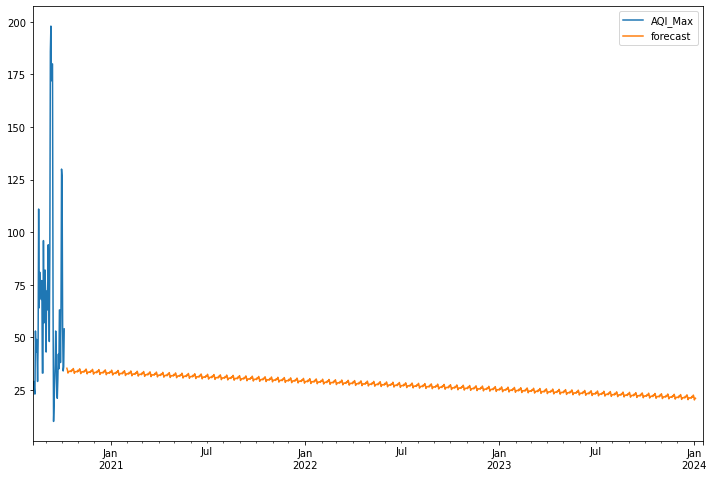

In [188]:
from pandas.tseries.offsets import DateOffset
future_datesE2=[df_E2.index[-1]+ DateOffset(days=x)for x in range(0,1200)]
future_datestE2_df=pd.DataFrame(index=future_datesE2[1:],columns=df_E2.columns)

future_datestE2_df.tail()

future_dfE2=pd.concat([df_E2,future_datestE2_df])

future_dfE2['forecast'] = results.predict(start = 2110, end = 3290, dynamic= True)#3650
future_dfE2[['AQI_Max', 'forecast']].plot(figsize=(12, 8))

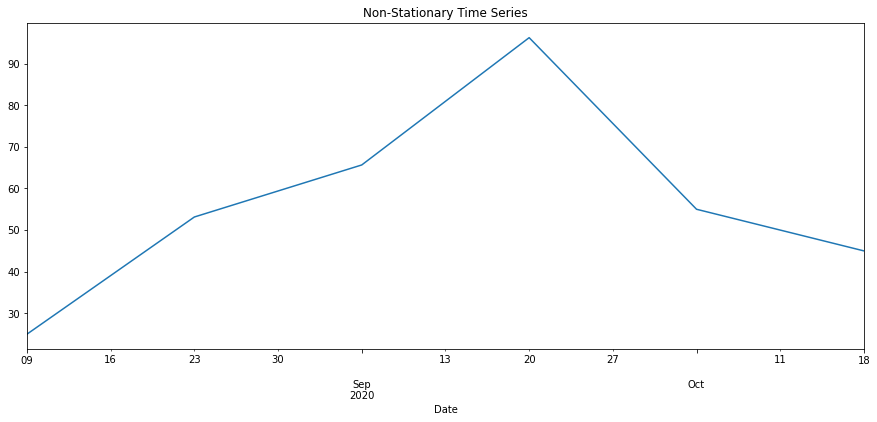

In [202]:
# Verifying & Vizualizing each pollutant's trend on a bi-weekly basis
AQI_Max = df_E2['AQI_Max'].resample('2W').mean()
AQI_Max.plot(figsize=(15, 6))
plt.title('Non-Stationary Time Series')
plt.show()

In [203]:
rcParams['figure.figsize'] = 18, 15
decomposition_max = sm.tsa.seasonal_decompose(AQI_Max, model='additive')
fig_max = decomposition_max.plot()
plt.title('AQI_Max Trends Analysis')
plt.show()

ValueError: x must have 2 complete cycles requires 104 observations. x only has 6 observation(s)

## Scenario 3: 03/04/2020 - 08/29/2020 
## 80% Reduction in Human Activity - Widespread

In [110]:
## Applying filters to dates

start_dateE3 = "2019-03-04"
end_dateE3 = "2020-08-29"

after_start_dateE3 = data["Date"] >= start_dateE3
before_end_dateE3 = data["Date"] <= end_dateE3
between_two_datesE3 = after_start_date & before_end_date
E3 = data.loc[between_two_datesE3]
E3.shape

(179, 7)

In [111]:
E3.head()

,Date,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
1889,2020-03-04,8.0,25.0,34.0,54.0,28.000000,54.0
1890,2020-03-05,6.0,21.0,34.0,39.0,16.812155,39.0
1891,2020-03-06,6.0,6.0,33.0,10.0,16.812155,33.0
1892,2020-03-07,6.0,8.0,36.0,4.0,16.812155,36.0
1893,2020-03-08,6.0,18.0,36.0,15.0,16.812155,36.0


In [112]:
E3.tail()

,Date,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
2063,2020-08-25,7.0,7.0,27.0,77.0,16.812155,77.0
2064,2020-08-26,2.0,4.0,25.0,33.0,16.812155,33.0
2065,2020-08-27,3.0,5.0,23.0,33.0,16.812155,33.0
2066,2020-08-28,13.0,6.0,24.0,96.0,16.812155,96.0
2067,2020-08-29,6.0,6.0,23.0,57.0,16.812155,57.0


In [113]:
# Set date as the index
E3 = E3.reset_index()

E3 = E3.set_index('Date')
E3.index
E3.tail()

,index,aqi_co,aqi_no2,aqi_o3,aqi_pm_2_5,aqi_pm_10,AQI_Max
Date,,,,,,,
2020-08-25,2063,7.0,7.0,27.0,77.0,16.812155,77.0
2020-08-26,2064,2.0,4.0,25.0,33.0,16.812155,33.0
2020-08-27,2065,3.0,5.0,23.0,33.0,16.812155,33.0
2020-08-28,2066,13.0,6.0,24.0,96.0,16.812155,96.0
2020-08-29,2067,6.0,6.0,23.0,57.0,16.812155,57.0


In [114]:
# Vizualizing all Pollutants 

figE3 = make_subplots(
    rows=6, cols=1,
    #specs=[[{}, {}],
          # [{"colspan": 6}, None]],
    subplot_titles=("aqi_co","aqi_no2","aqi_o3","aqi_pm_2_5",'aqi_pm_10','AQI_Max'))

figE3.add_trace(go.Bar(x=E3.index, y=E3['aqi_co'],
                    marker=dict(color=E3['aqi_co'],coloraxis="coloraxis")),
              1, 1)
figE3.add_trace(go.Bar(x=E3.index, y=E3['aqi_no2'],
                    marker=dict(color=E3['aqi_no2'], coloraxis="coloraxis")),
              2, 1)
figE3.add_trace(go.Bar(x=E3.index, y=E3['aqi_o3'],
                    marker=dict(color=E3['aqi_o3'], coloraxis="coloraxis")),
              3, 1)
figE3.add_trace(go.Bar(x=E3.index, y=E3['aqi_pm_2_5'],
                    marker=dict(color=E3['aqi_pm_2_5'], coloraxis="coloraxis")),
              4, 1)
figE3.add_trace(go.Bar(x=E3.index, y=E3['aqi_pm_10'],
                    marker=dict(color=E3['aqi_pm_10'], coloraxis="coloraxis")),
              5, 1)
figE3.add_trace(go.Bar(x=E3.index, y=E3['AQI_Max'],
                    marker=dict(color=E3['AQI_Max'], coloraxis="coloraxis")),
              6, 1)

figE3.update_layout(coloraxis=dict(colorscale='Temps'),showlegend=False,title_text="AQI Levels From 03/04/2020 - 08/29/2020")

figE3.update_layout(plot_bgcolor='white')

# figE2.update_layout( width=800,height=1200,shapes=[
#       dict(
#       type= 'line',
#       yref= 'paper', y0= 0, y1= 1,
#       xref= 'x', x0= '2020-08-09', x1= '2020-08-09'
#     )
# ])

figE3.update_layout( width=800,height=1200)

figE3.show()

In [157]:
## create new dataframe with AQI_Max

df_E3 = E3[["AQI_Max"]]
df_E3.head()

,AQI_Max
Date,
2020-03-04,54.0
2020-03-05,39.0
2020-03-06,33.0
2020-03-07,36.0
2020-03-08,36.0


In [158]:
resultE3=adfuller(df_E3['AQI_Max'])

In [159]:
#check that if the dataset is stationary or not
#Ho: It is non-stationary
#H1: It is stationary

def adfuller_test(AQI_Max):
    resultE3=adfuller(AQI_Max)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(resultE3,labels):
        print(label+' : '+str(value) )

if resultE3[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df_E3['AQI_Max'])

weak evidence against null hypothesis,indicating it is non-stationary 
ADF Test Statistic : -2.2945727764880712
p-value : 0.1737243341933083
#Lags Used : 9
Number of Observations : 169


In [160]:
df_E3['AQI_Max First Difference'] = df_E3['AQI_Max'] - df_E3['AQI_Max'].shift(1)
df_E3['Seasonal First Difference']=df_E3['AQI_Max']-df_E3['AQI_Max'].shift(12)
df_E3.head()

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AQI_Max,AQI_Max First Difference,Seasonal First Difference
Date,,,
2020-03-04,54.0,NaN,NaN
2020-03-05,39.0,-15.0,NaN
2020-03-06,33.0,-6.0,NaN
2020-03-07,36.0,3.0,NaN
2020-03-08,36.0,0.0,NaN


In [161]:
#see the first difference and seasonal difference
adfuller_test(df_E3['Seasonal First Difference'].dropna())

ADF Test Statistic : -4.995752586932941
p-value : 2.262675087552996e-05
#Lags Used : 11
Number of Observations : 155


In [162]:
#see the first difference and seasonal difference
adfuller_test(df_E3['AQI_Max First Difference'].dropna())

ADF Test Statistic : -7.622472863858956
p-value : 2.1105868078551434e-11
#Lags Used : 7
Number of Observations : 170


In [163]:
#Fit model
modelE3=ARIMA(df_E3['AQI_Max'],order=(1,1,1))
modelE3_fit=modelE3.fit()
modelE3_fit.summary()

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.AQI_Max   No. Observations:                  178
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -683.402
Method:                       css-mle   S.D. of innovations             11.230
Date:                Wed, 28 Apr 2021   AIC                           1374.804
Time:                        19:46:03   BIC                           1387.532
Sample:                    03-05-2020   HQIC                          1379.966
                         - 08-29-2020                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1171      0.218      0.537      0.591      -0.311       0.545
ar.L1.D.AQI_Max     0.3539      0.124      2.849      0.004       0.110       0.597
ma.L1.D.AQI_Max    -0.8369      0.083    -10.104      0.000      -0.999      -0.675
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.8260           +0.0000j            2.8260            0.0000
MA.1            1.1949           +0.0000j            1.1949            0.0000
-----------------------------------------------------------------------------
"""

/Users/nataliavelasquez/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2292: ValueWarning:

Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.



<AxesSubplot:>

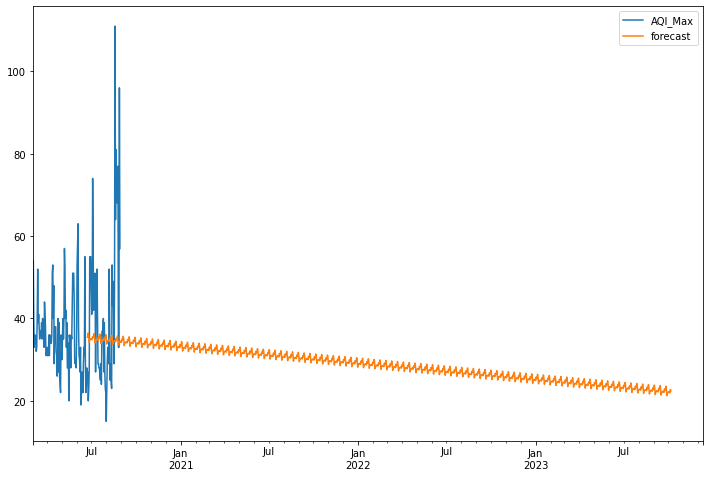

In [194]:
from pandas.tseries.offsets import DateOffset
future_datesE3=[df_E3.index[-1]+ DateOffset(days=x)for x in range(0,1200)]
future_datestE3_df=pd.DataFrame(index=future_datesE3[1:],columns=df_E3.columns)

future_datestE3_df.tail()

future_dfE3=pd.concat([df_E3,future_datestE3_df])

future_dfE3['forecast'] = results.predict(start = 2000, end = 3200, dynamic= True)#3650
future_dfE3[['AQI_Max', 'forecast']].plot(figsize=(12, 8))

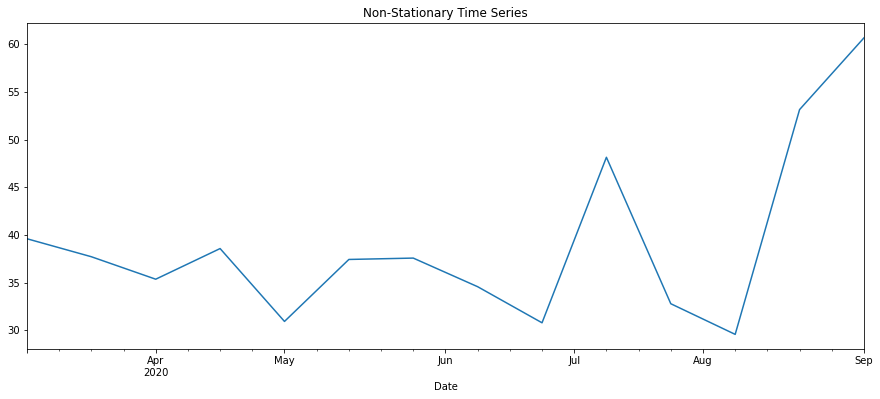

In [208]:
# Verifying & Vizualizing each pollutant's trend on a bi-weekly basis
AQI_Max = df_E3['AQI_Max'].resample('2W').mean()
AQI_Max.plot(figsize=(15, 6))
plt.title('Non-Stationary Time Series')
plt.show()

In [209]:
rcParams['figure.figsize'] = 18, 15
decomposition_max = sm.tsa.seasonal_decompose(AQI_Max, model='additive')
fig_max = decomposition_max.plot()
plt.title('AQI_Max Trends Analysis')
plt.show()

ValueError: x must have 2 complete cycles requires 104 observations. x only has 14 observation(s)